In [57]:
import sys
print(sys.executable)

c:\Users\konne\.anaconda3\envs\cv\python.exe


In [58]:
import cv2 as cv
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

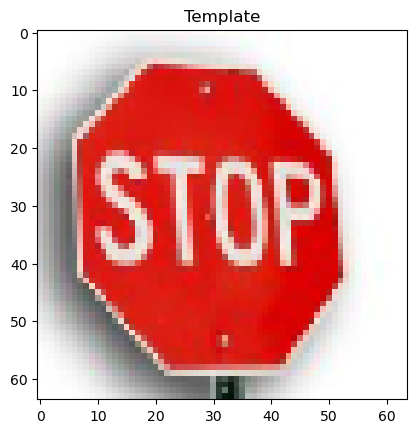

In [59]:
T = cv.imread('data/traffic-stop-signs/template-1-2.png')
T = cv.cvtColor(T, cv.COLOR_BGR2RGB)
T = cv.resize(T, (64,64))

plt.title('Template')
plt.imshow(T, cmap='gray');


(400, 300, 3)


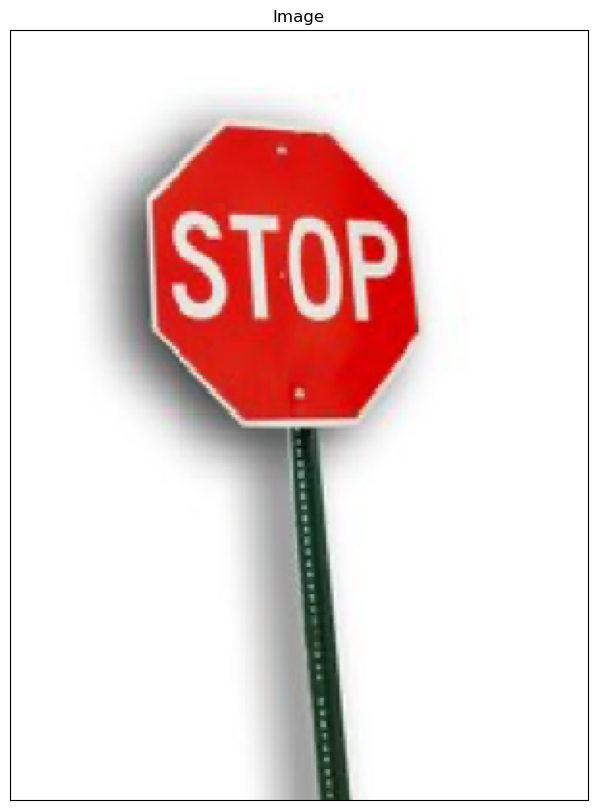

In [60]:
I = cv.imread('data/traffic-stop-signs/traffic-stop-2.png')
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
print(I.shape)

plt.figure(figsize=(10,10))
plt.title('Image')
plt.imshow(I, cmap='gray')
plt.xticks([])
plt.yticks([]);

In [61]:

def find_stop_sign(T, I):
    """
    Given a traffic stop sign template T and an image I, returns the bounding box
    for the detected stop sign.

    A bounding box is defined as: [top, left, height, width]
    Return [0,0,1,1] if not found.
    """
    if T is None or I is None:
        return np.array([0, 0, 1, 1], dtype=int)

    # Convert to grayscale (OpenCV images are typically BGR)
    T_gray = cv.cvtColor(T, cv.COLOR_BGR2GRAY) if len(T.shape) == 3 else T
    I_gray = cv.cvtColor(I, cv.COLOR_BGR2GRAY) if len(I.shape) == 3 else I

    plt.figure(figsize=(5,5))
    plt.title("Template (grayscale)")
    plt.imshow(T_gray, cmap="gray")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(5,5))
    plt.title("Image (grayscale)")
    plt.imshow(I_gray, cmap="gray")
    plt.axis("off")
    plt.show()
    

    # Convert to float32
    T_gray = T_gray.astype(np.float32)
    I_gray = I_gray.astype(np.float32)

    h, w = T_gray.shape

    # Template match
    R = cv.matchTemplate(I_gray, T_gray, cv.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv.minMaxLoc(R)

    # Pick a realistic threshold
    threshold = 0.5   # try 0.65–0.85 depending on your images

    if max_val >= threshold:
        left, top = max_loc  # (x, y)
        bbox = [top, left, h, w]

        # (optional) show detection
        identified = I_gray[top:top+h, left:left+w]
        plt.figure(figsize=(5,5))
        plt.title(f"Detected (score={max_val:.3f})")
        plt.imshow(identified, cmap="gray")
        plt.axis("off")
        plt.show()
    else:
        bbox = [0, 0, 1, 1]

    return np.array(bbox, dtype=int)


In [62]:
def debug_match(T, I):
    if T is None or I is None:
        print("T or I is None")
        return

    T_gray = cv.cvtColor(T, cv.COLOR_RGB2GRAY) if len(T.shape) == 3 else T
    I_gray = cv.cvtColor(I, cv.COLOR_RGB2GRAY) if len(I.shape) == 3 else I

    T_gray = T_gray.astype(np.float32)
    I_gray = I_gray.astype(np.float32)

    R = cv.matchTemplate(I_gray, T_gray, cv.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)

    print(f"R shape: {R.shape}")
    print(f"min_val={min_val:.4f}, max_val={max_val:.4f}, min_loc={min_loc}, max_loc={max_loc}")

    plt.figure(figsize=(8,6))
    plt.title("Match response R (heatmap)")
    plt.imshow(R, cmap="inferno")
    plt.colorbar()
    plt.axis("off")
    plt.show()

In [ ]:
def highlight(R, T, I, use_max=True):
    """
    Finds the location of maximum (or minimum) matching response, and 
    draws a rectangle on the image around this location.  The
    size of the rectangle is determined by template T.
    
    Returns an image with the drawn rectangle.  Also returns the loc and
    the value (maximum or minimum as the case may be).  The original image
    remains unchanged.s
    """
    
    W, H = I.shape[0], I.shape[1]
    w, h = T.shape[0], T.shape[1]
    wr, hg = R.shape[0], R.shape[1]
        
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
    loc = max_loc if use_max else min_loc
    val = max_val if use_max else min_val
    
    loc1 = loc + np.array([h//2, w//2])               # Size of R is different from I 
    tl = loc1 - np.array([h//2, w//2])
    br = loc1 + np.array([h//2, w//2])
    I_ = np.copy(I)
    c = (1.0, 0, 0) if I_.dtype == 'float32' else (255, 0, 0)
    cv.rectangle(I_, tuple(tl), tuple(br), c, 4)
    return I_, loc, val

In [64]:
def find_loc_and_value_in_R(R, use_max=True):
    """
    Finds the location of maximum (or minimum) matching response.
    """
    
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
    loc = max_loc if use_max else min_loc
    val = max_val if use_max else min_val
    
    return loc, val

In [65]:
def draw_rect(I, bbox):

    I_ = np.copy(I)
    c = (1.0, 0, 0) if I_.dtype == 'float32' else (255, 0, 0)
    cv.rectangle(I_, (bbox[1], bbox[0]), (bbox[1]+bbox[3], bbox[0]+bbox[2]), c, 4)
    return I_

In [66]:
def gen_gaussian_pyramid(I, levels):
    G = I.copy()
    gpI = [G]
    for i in range(levels):
        G = cv.pyrDown(G)
        gpI.append(G)
    return gpI

In [67]:
def visualize_guassian_pyramid(gpI):
    I = gpI[0]
    h, w = I.shape[0], I.shape[1]
    
    if len(I.shape) == 3:
        result = np.empty([h, 2*w, I.shape[2]], dtype=I.dtype)
    else:
        result = np.empty([h, 2*w], dtype=I.dtype)
    
    x = 0
    for I_ in gpI:
        if len(I.shape) == 3:
            h, w, _ = I_.shape
            result[:h,x:x+w,:] = I_
        else:
            h, w = I_.shape
            result[:h,x:x+w] = I_
        x += w
    
    return result

In [68]:
def make_square(I):
    h = I.shape[0]
    w = I.shape[1]
    
    n_levels = np.int(np.ceil(np.log(np.max([h,w]))/np.log(2)))
    new_h = np.power(2, n_levels)
    new_w = new_h
    
    if len(I.shape) == 3:
        tmp = np.zeros([new_h, new_w, I.shape[2]], dtype=I.dtype)
        tmp[:h,:w,:] = I
    else:
        tmp = np.zeros([new_h, new_w], dtype=I.dtype)
        tmp[:h,:w] = I

    return tmp, n_levels

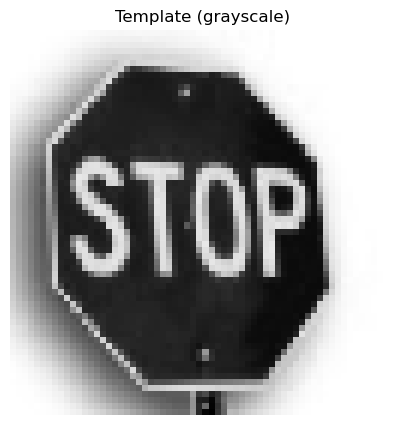

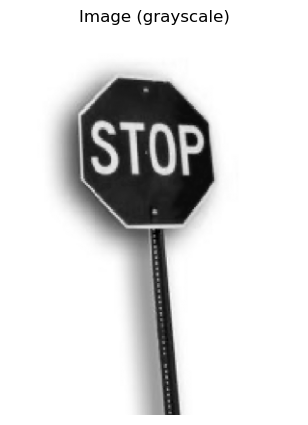

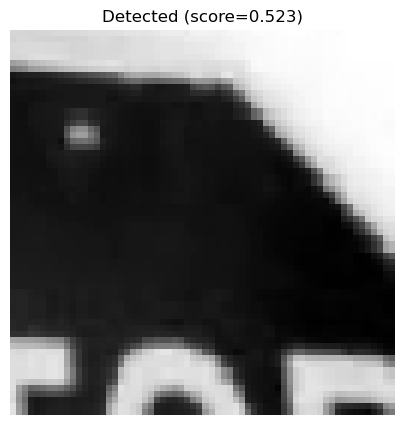

R shape: (337, 237)
min_val=-0.5857, max_val=0.5215, min_loc=(72, 220), max_loc=(129, 45)


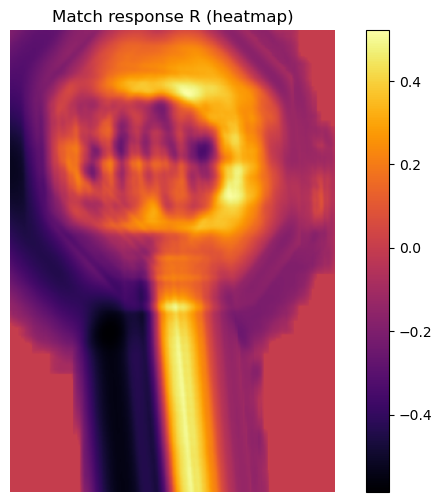

Bbox = [ 45 129  64  64]


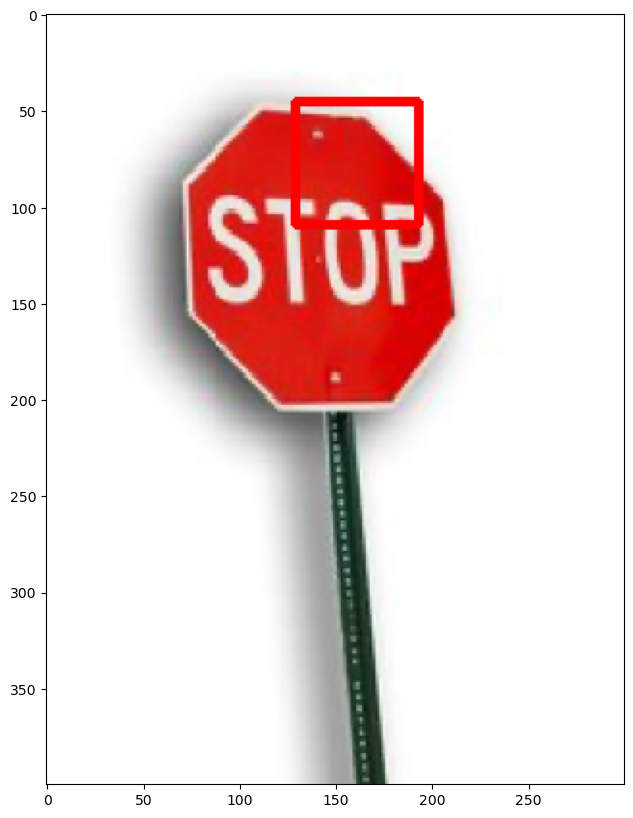

In [69]:
bbox = find_stop_sign(T, I)
debug_match(T, I)
print(f'Bbox = {bbox}')

plt.figure(figsize=(10,10))
I_ = draw_rect(I, bbox)
plt.imshow(I_, cmap='gray');

In [ ]:
# Use the CLI-ready module from the notebook.
from stopsign import load_image, load_template, detect_stop_sign, draw_bbox
import cv2 as cv
import matplotlib.pyplot as plt
import os

base_dir = os.path.dirname(os.path.abspath("."))
template_path = os.path.join(base_dir, "data", "traffic-stop-signs", "template-1-2.png")
image_path = os.path.join(base_dir, "images", "road62.png")
template = load_template(template_path)
image = load_image(image_path)

detected, bbox, score = detect_stop_sign(image, template, threshold=0.5)
print("Detected:", "Yes" if detected else "No", "Score:", f"{score:.3f}")

if detected:
    image = draw_bbox(image, bbox)

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.axis("off");